In [8]:
import cv2
from glob import glob
import numpy as np
from PIL import Image, ImageOps
from tqdm import tqdm
from tqdm.notebook import tqdm
import tensorflow as tf
import PIL.ImageOps

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Add
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))
    
    resized = cv2.resize(image, dim, interpolation = inter)

    return resized

def slicer(images, names, segment=80, timeAxis=False):
    half = segment // 4
    retImg = []
    retClass = []
    
    for img, name in zip(images, names):
        if timeAxis:
            timeImage = []

        for i in range(0, img.shape[1], half):
            if i + half * 3 > img.shape[1]:
                continue
            
            tmp = img[:, i:i + segment]
            tmp = np.pad(tmp, ((0, 0), (0, segment - tmp.shape[1])), 'constant', constant_values=0)

            if timeAxis:
                timeImage.append(tmp)
            else:
                retImg.append(tmp)
                retClass.append(name)

        if timeAxis and len(timeImage) > 0:  
            retImg.append(np.stack(timeImage))
            retClass.append(name)

    return retImg, retClass
def loadData(perClassData=None, h=80):

    imgFiles = glob("./data/temp_sentences/*.png")
    print(len(imgFiles), 'images found.')

    ImageArray = []
    Names = []

    for imgFile in tqdm(imgFiles):  
        fileName = (imgFile.split('/')[-1]).split('.')[0]
        name = fileName.split('-')[0]                           

        img = Image.open(imgFile)
        img = PIL.ImageOps.invert(img)
        image = image_resize(np.array(img, dtype=np.uint8), height=h)
        
        if image.ndim > 2:
            continue

        image = image / 255
        ImageArray.append(image)
        Names.append(name)
    
    print('Total Unique Classes', len(np.unique(Names)))
    return ImageArray, Names  


In [13]:
X, y = loadData(60, h=113)

4909 images found.


  0%|          | 0/4909 [00:00<?, ?it/s]

Total Unique Classes 25


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=40)

XX_test, yy_test = slicer(X_test, y_test, segment=113, timeAxis=True)


In [7]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder().fit(np.array(y).reshape(-1, 1))

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train_OHE = OHE.fit_transform(y_train).toarray()
y_test_OHE = OHE.transform(y_test).toarray()

In [6]:

def halfDeepWriter(input_shape, classes, frac=1):
    patch_1 = Input(shape=input_shape)

    out1 = Conv2D(int(96*frac), kernel_size=5, strides=2, activation='relu')(patch_1)
    out1 = MaxPooling2D(3, strides=2)(out1)

    out1 = Conv2D(int(256*frac), kernel_size=3, activation='relu')(out1)
    out1 = MaxPooling2D(3, strides=2)(out1)

    out1 = Conv2D(int(384*frac), kernel_size=3, activation='relu')(out1)
    out1 = Conv2D(int(384*frac), kernel_size=3, activation='relu')(out1)
    out1 = Conv2D(int(256*frac), kernel_size=3, activation='relu')(out1)
    out1 = MaxPooling2D(3, strides=2)(out1)

    out1 = Flatten()(out1)
    out1 = Dense(int(1024*frac), activation='relu')(out1)
    out1 = Dropout(0.5)(out1)

    out1 = Dense(int(1024*frac), activation='relu')(out1)
    out1 = Dropout(0.5)(out1)

    out1 = Dense(classes, activation='softmax')(out1)

    model = Model(inputs=patch_1, outputs=out1)
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['acc'])

    return model

In [10]:
import tensorflow

class dataGeneratorHalfDeepWriter(tensorflow.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, w=80):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.inputX = X
        self.inputY = y
        self.w = w
        self.h = self.inputX[0].shape[0]
        self.total = len(X)
        self.indexes = np.arange(self.total)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.total / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batchIndexes):
        X = np.zeros((self.batch_size, self.h, self.w))
        y = np.empty((self.batch_size, self.inputY.shape[-1]), dtype=int)
        
        for i, ID in enumerate(batchIndexes):
           
            tmpImg = np.zeros((self.h, self.w))
            y_pos1 = int(np.random.randint(low=0,high=max(self.inputX[ID].shape[1]-self.w//3, 1),size=1))
            tmpImg1 = (self.inputX[ID])[:, y_pos1:y_pos1+self.w]
            X[i, 0:tmpImg1.shape[0], 0:tmpImg1.shape[1]] = tmpImg1
            y[i] = self.inputY[ID]

        X = X[:, :, :, np.newaxis]
        return X, y


In [ ]:
model = halfDeepWriter((113, 113, 1), 25)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 113, 113, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │        25,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,446,361 (20.78 MB)

 Trainable params: 5,446,361 (20.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#training
train_gen = dataGeneratorHalfDeepWriter(X_train, y_train_OHE, batch_size=128, w=113)
test_gen = dataGeneratorHalfDeepWriter(X_test, y_test_OHE, batch_size=128, w=113)

hist = model.fit(train_gen, validation_data=test_gen, epochs=50, 
                 callbacks=[ ModelCheckpoint(filepath='/content/best.keras',
                             save_best_only=True, monitor='acc', mode='max',
                            ), ])

print("Model Trained")

c:\Users\fast\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\fast\AppData\Local\Temp\ipykernel_22320\3605626647.py:105: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pos1 = int(np.random.randint(low=0,high=max(self.inputX[ID].shape[1]-self.w//3, 1),size=1))


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - acc: 0.1989 - loss: 3.1587 - val_acc: 0.3125 - val_loss: 2.5274
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - acc: 0.3389 - loss: 2.4759 - val_acc: 0.3002 - val_loss: 2.5248
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - acc: 0.3327 - loss: 2.4556 - val_acc: 0.3069 - val_loss: 2.5189
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - acc: 0.3208 - loss: 2.4794 - val_acc: 0.3092 - val_loss: 2.4665
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - acc: 0.3251 - loss: 2.4541 - val_acc: 0.3036 - val_loss: 2.4727
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - acc: 0.3265 - loss: 2.3772 - val_acc: 0.3259 - val_loss: 2.3424
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - acc: 0.3432 - loss: 2.3158 - val_acc: 0.3348 - val_loss: 2.2449
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - acc: 0.3495 - loss: 2.2598 - val_acc: 0.3259 - val_loss: 2.2171
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - acc: 0.3614 

In [ ]:
model.save("my_model.keras")
print("Model saved")

Model saved


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []

for batch, tar in zip(XX_test, y_test_OHE):
    if batch.shape[0] <= 0:
        continue
    batch = batch[:, :, :, np.newaxis]
    y_pred.append(np.argmax(np.sum(model.predict(batch), axis=0), axis=0))
    y_true.append(np.argmax(tar))

accuracy_score(y_true, y_pred)
print("Trained accuracy: ", accuracy_score(y_true, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1

In [16]:
!pip install seaborn

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

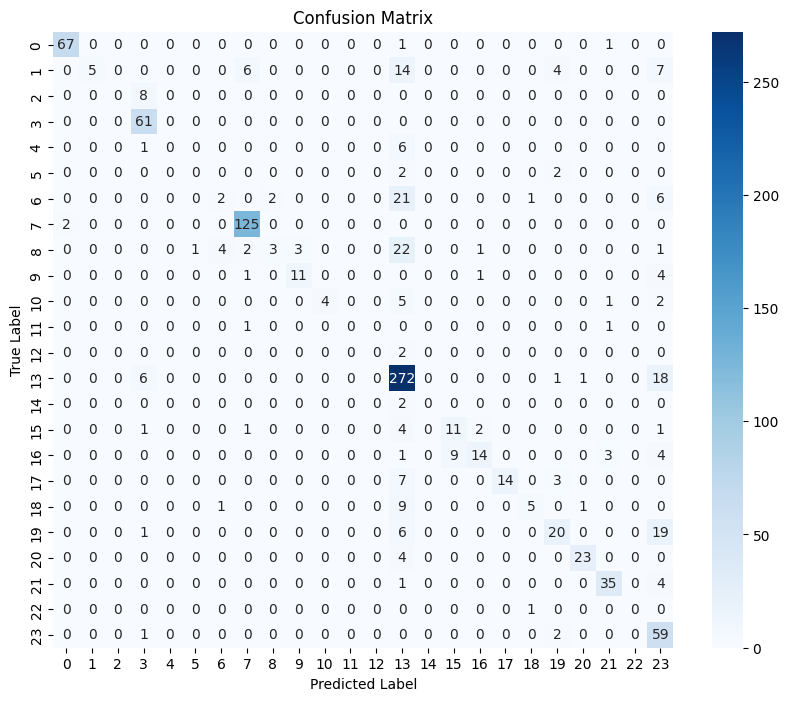


Classification Report:
              precision    recall  f1-score   support

           0     0.9710    0.9710    0.9710        69
           1     1.0000    0.1389    0.2439        36
           2     0.0000    0.0000    0.0000         8
           3     0.7722    1.0000    0.8714        61
           4     0.0000    0.0000    0.0000         7
           5     0.0000    0.0000    0.0000         4
           6     0.2857    0.0625    0.1026        32
           7     0.9191    0.9843    0.9506       127
           8     0.6000    0.0811    0.1429        37
           9     0.7857    0.6471    0.7097        17
          10     1.0000    0.3333    0.5000        12
          12     0.0000    0.0000    0.0000         2
          13     0.0000    0.0000    0.0000         2
          14     0.7177    0.9128    0.8035       298
          15     0.0000    0.0000    0.0000         2
          16     0.5500    0.5500    0.5500        20
          17     0.7778    0.4516    0.5714        31
   

c:\Users\fast\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fast\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fast\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
y_true = []

for batch, tar in zip(XX_test, y_test_OHE):
    if batch.shape[0] <= 0:
        continue
    batch = batch[:, :, :, np.newaxis]  
    prediction = model.predict(batch)
    summed = np.sum(prediction, axis=0)
    y_pred.append(np.argmax(summed))
    y_true.append(np.argmax(tar))

accuracy = accuracy_score(y_true, y_pred)
print("Trained accuracy:", accuracy)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print("\nClassification Report:")
print(report)


In [3]:
from keras.models import load_model
model = load_model("my_model.keras")

In [11]:
model = halfDeepWriter((113, 113, 1), 25)  
model.load_weights("/content/best.keras")

c:\Users\fast\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
unique_writer_ids = np.unique(y)
writer_mapping = {index: writer_id for index, writer_id in enumerate(unique_writer_ids)}

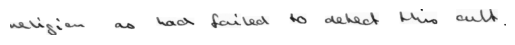

In [15]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# # img_path = './data/Demo/test1.png' #writer ID p06
# img_path = './data/Demo/test2.png' #writer ID r06
img_path = './data/Demo/test3.png' #writer ID g06
# img_path = './data/Demo/test4.png' #writer ID a01
# img_path = './data/Demo/test5.png' #writer ID j06
# img_path = './data/Demo/test6.png' #writer ID jo6

img = imageio.imread(img_path)
plt.imshow(img, cmap='gray') 
plt.axis('off')
plt.show()

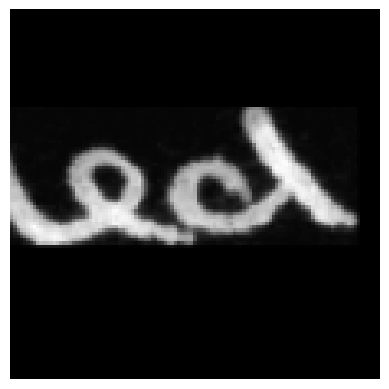

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
The predicted writer is: temp_sentences\g06


In [16]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

def preprocess_image(img_path, height=113, width=113):
    img = Image.open(img_path)
    img = PIL.ImageOps.invert(img)
    image_arr = image_resize(np.array(img, dtype=np.uint8), height=height)  # Resize based on height

    if image_arr.shape[1] > width:  
        start_col = (image_arr.shape[1] - width) // 2
        image_arr = image_arr[:, start_col:start_col + width]
    elif image_arr.shape[1] < width:  
        pad_amt = width - image_arr.shape[1]
        pad_left = pad_amt // 2
        pad_right = pad_amt - pad_left
        image_arr = np.pad(image_arr, ((0, 0), (pad_left, pad_right)), mode='constant', constant_values=0)

    if image_arr.ndim > 2:
        return None
    image_arr = image_arr / 255.0
    return image_arr

# # img_path = './data/Demo/test1.png' #writer ID p06
# img_path = './data/Demo/test2.png' #writer ID r06
img_path = './data/Demo/test3.png' #writer ID g06
# img_path = './data/Demo/test4.png' #writer ID a01
# img_path = './data/Demo/test5.png' #writer ID j06
# img_path = './data/Demo/test6.png' #writer ID jo6

img_array = preprocess_image(img_path)

if img_array is not None:
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')
    plt.show()

    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=3)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    predicted_writer_id = writer_mapping[predicted_class]
    print(f"The predicted writer is: {predicted_writer_id}")
else:
    print("The image could not be processed.")


In [17]:
print(f"The predicted writer is: {predicted_writer_id}")

The predicted writer is: temp_sentences\g06
